##0. Importing torch and setting up Agnostic code

In [2]:
import torch
from torch import nn

print(torch.__version__)

2.1.0+cpu


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device:{device}')

Device:cpu


In [4]:
!nvidia-smi

Tue Oct  8 14:23:54 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 556.12                 Driver Version: 556.12         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce MX330         WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   69C    P0             N/A / ERR!  |       0MiB /   2048MiB |      2%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1. Creating the dataset

We create a small dataset (10%) using the Food101 dataset from torchvision.datasets

Link: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb

## 2. Get dataset

In [5]:
import requests
import zipfile
from pathlib import Path

#Path for data
data_path=Path('data/')
image_path=data_path / "pizza_steak_sushi"

#Creating directory
if image_path.is_dir():
  print(f"{image_path} directory already exists... skipping download")
else:
  print(f"Creating directory {image_path}")
  image_path.mkdir(parents=True,exist_ok=True)

#Download data
with open(data_path/'pizza_steak_sushi.zip','wb') as f:
  request=requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
  print("Downloading the data...")
  f.write(request.content)

#Unzip file
with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip','r') as zip_ref:
  print("Unzipping file...")
  zip_ref.extractall(image_path)
  print("Completed...")

data\pizza_steak_sushi directory already exists... skipping download
Unzipping file...
Completed...


## 3. Data Exploration

In [6]:
import os
def walkthrough_dir(dir_path):
  for dirpath,dirname,filename in os.walk(dir_path):
    print(f'There are {len(dirname)} directories and {len(filename)} images in {dirpath}.')
walkthrough_dir(image_path)

There are 2 directories and 0 images in data\pizza_steak_sushi.
There are 3 directories and 0 images in data\pizza_steak_sushi\test.
There are 0 directories and 25 images in data\pizza_steak_sushi\test\pizza.
There are 0 directories and 19 images in data\pizza_steak_sushi\test\steak.
There are 0 directories and 31 images in data\pizza_steak_sushi\test\sushi.
There are 3 directories and 0 images in data\pizza_steak_sushi\train.
There are 0 directories and 78 images in data\pizza_steak_sushi\train\pizza.
There are 0 directories and 75 images in data\pizza_steak_sushi\train\steak.
There are 0 directories and 72 images in data\pizza_steak_sushi\train\sushi.


In [7]:
#Setup train and test paths
train_dir=image_path/"train"
test_dir=image_path/'test'

train_dir,test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

Random image Path: data\pizza_steak_sushi\test\sushi\2394442.jpg
Image class: sushi
Iamge Height: 408
Image width: 512


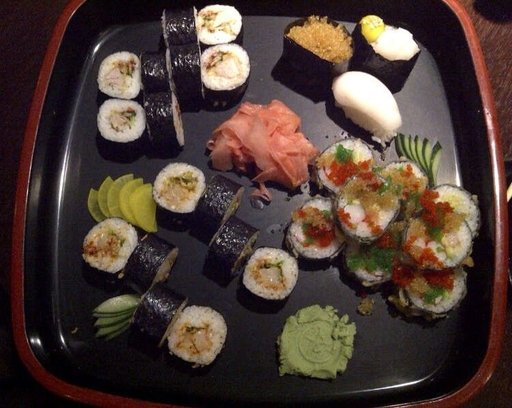

In [8]:
#Visualization a random image

import random
from PIL import Image

random.seed(42)

#Get all image paths
image_path_list=list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

#Pick random image
random_image_path=random.choice(image_path_list)
random_image_path

#Get image class (i.e the directory in which image is stored)
image_class=random_image_path.parent.stem
image_class

#Display image
img=Image.open(random_image_path)

#Metadata for image
print(f"Random image Path: {random_image_path}")
print(f'Image class: {image_class}')
print(f'Iamge Height: {img.height}')
print(f'Image width: {img.width}')
img

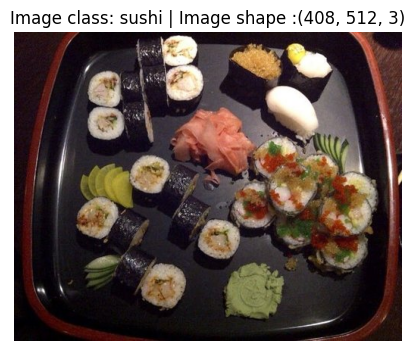

In [9]:
#Visualize using matplotlib
import numpy as np
import matplotlib.pyplot as plt

img_array=np.array(img)

plt.figure(figsize=(5,5))
plt.imshow(img_array)
plt.title(f"Image class: {image_class} | Image shape :{img_array.shape}")
plt.axis(False)
plt.show()

## 4. Transforming the Data

We convert the images to tensor to work with Pytorch.
Also turn it into `torh.utils.data.Datasets` adn subsequently a `torch.utils.data.DataLoader`

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets,transforms

### Transforming data to `torchvision.transforms`

In [11]:
#Write transform for image
data_transform=transforms.Compose([
    #Resize the images (64x64)
    transforms.Resize(size=(64,64)),

    #Flip the images
    transforms.RandomHorizontalFlip(p=0.5),

    #Turn the image to torch tensor
    transforms.ToTensor()
])

In [12]:
data_transform(img).shape

torch.Size([3, 64, 64])

In [13]:
str(random_image_path)

'data\\pizza_steak_sushi\\test\\sushi\\2394442.jpg'

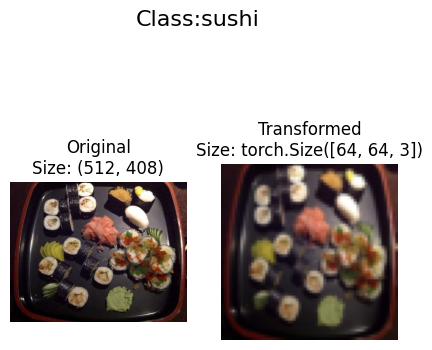

In [14]:
def plot_transformed_image(image_path,transform,n=3,seed=None):
  if seed:
    random.seed(seed)
  random_image_paths=random.sample(image_path,k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(5,5))
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      #Transform
      transformed_image=transform(f).permute(1,2,0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nSize: {transformed_image.shape}")
      ax[1].axis(False)
      
      fig.suptitle(f"Class:{image_path.parent.stem}",fontsize=16)

plot_transformed_image(image_path_list,data_transform,1,42)

### Option 1: Loading image data using `ImageFolder`

In [15]:
#Use ImageFolder to create dataset
from torchvision import datasets
train_data=datasets.ImageFolder(root=train_dir,
                          transform=data_transform,
                          target_transform=None)

test_data=datasets.ImageFolder(root=test_dir,
                          transform=data_transform,
                          target_transform=None)

train_data,test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [16]:
#Get class names as a list
class_names=train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [17]:
#Get class names as dictionary
class_dict=train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [18]:
#length of data
len(train_data),len(test_data)

(225, 75)

In [19]:
train_data.samples[0]

('data\\pizza_steak_sushi\\train\\pizza\\1008844.jpg', 0)

Image Tensor:
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

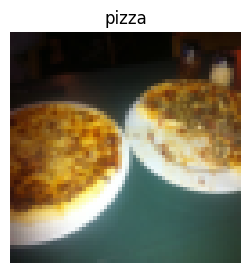

In [20]:
img,label=train_data[0][0],train_data[0][1]
print(f'Image Tensor:\n{img}')
print(f'Image shape: {img.shape}')
print(f'Image datatype: {img.dtype}')
print(f'Image label: {label}')
print(f'Image label datatype: {type(label)}')

plt.figure(figsize=(3,3))
plt.imshow(img.permute(1,2,0))
plt.axis(False)
plt.title(f"{class_names[label]}")
plt.show()

#### Turn loaded images to Data Loader

In [21]:
from torch.utils.data import DataLoader
import os

BATCH_SIZE=1
train_dataloader=DataLoader(dataset=train_data,
                            batch_size=BATCH_SIZE,
                            num_workers=1,#os.cpu_count()
                            shuffle=True)

test_dataloader=DataLoader(dataset=test_data,
                            batch_size=BATCH_SIZE,
                            num_workers=1,#os.cpu_count()
                            shuffle=False)

train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x211fc715450>,
 <torch.utils.data.dataloader.DataLoader at 0x211fe886d40>)

In [22]:
len(train_dataloader),len(test_dataloader)

(225, 75)

In [23]:
img,label=next(iter(train_dataloader))
print(f"Image Shape: {img.shape}")
print(f'Image label: {label.shape}')

Image Shape: torch.Size([1, 3, 64, 64])
Image label: torch.Size([1])


### Option 2: Creating our own Image Data Loading Class

* Want to be able to load images from file.
* Want to be able to get class names from the Dataset.
* Want to be able to get classes as dictionary from the dataset.

Pros:
  * Can create a `Dataset` out of almost anything.
  * Not limited to Pytorch pre_built `Dataset` functions.

Cons:
  * Even though we create `Dataset` out of almost anything, it doesn't mean it will work
  * Using a custom `Dataset` often results in us writing more code, which could be prone to errors or performance issues.

In [24]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple,Dict,List

In [25]:
#Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

#### Creating helper functions to get class names

1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format)
2. Raise and error if class names are not found.
3. Turn the class names into dict and a list and return them.

In [27]:
#Setup path directory
target_dir=train_dir
print(f"Target Directory: {target_dir}")

#Get the class names from teh target directory
class_names_found=sorted([entry.name for entry in list(os.scandir(target_dir))])
class_names_found

Target Directory: data\pizza_steak_sushi\train


['pizza', 'steak', 'sushi']

In [28]:
def find_classes(dir:str)->Tuple[List[str],Dict[str,int]]:
  '''finds the class folder name in target directory'''
  #Get the class names by scanning directory
  classes=sorted(entry.name for entry in os.scandir(dir) if entry.is_dir())

  #Raise an error if classes are not found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {dir}. Please check file structure.")
  
  # Create a ditionary of index labels
  class_to_idx={class_name:i for i,class_name in enumerate(classes)}

  return classes, class_to_idx

####Create a custom `Dataset` class to replicate the `ImageFolder`

1. Subclass `torch.utils.data.Dataset` class
2. Init the subclass with the target directory as well as transform if we'd like to transform our data.
3. Create several attributes:
  * paths- paths of our images
  * transform- the transform we like to use
  * classes- a list of target classes
  * clas_to_idx- a dict of the target classes mapped to integer labels,
4. Create a function to `load_images()` to open images.
5. Overwrite the `__len__()` method to return the length of dataset
6. Overwrite the `__getitem__()` method to return a given sample when passed an index

In [29]:
#Write a custom dataset class
from torch.utils.data import Dataset

#Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  #Initialize the custom dataset
  def __init__(self, target_dir:str, transform=None):
    #Create class attributes
    self.paths=list(pathlib.Path(target_dir).glob("*/*.jpg"))
    self.transform=transform
    self.classes,self.classes_to_idx=find_classes(target_dir)
  
  #Fucntion to load images
  def load_image(self,index:int)->Image.Image:
    'Open a image through a path and return it'
    image_path=self.paths[index]
    return Image.open(image_path)

  #Overwrite the len method
  def __len__(self)->int:
    return len(self.paths)

  #Overwrite the getitem() fucntion
  def __getitem__(self,index:int,)->Tuple[torch.Tensor,int]:
    img=self.load_image(index)
    class_name=self.paths[index].parent.name
    class_idx=self.classes_to_idx[class_name]
    
    #Transform if necessary
    if self.transform:
      return self.transform(img),class_idx
    else:
      return img,class_idx

In [30]:
#Creating a transform
from torchvision import transforms
train_transforms=transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms=transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [31]:
#Test the ImageFolderCustom
train_data_custom=ImageFolderCustom(train_dir,train_transforms)
test_data_custom=ImageFolderCustom(test_dir,test_transforms)

In [32]:
train_data_custom,test_data_custom

(<__main__.ImageFolderCustom at 0x211fe8fbaf0>,
 <__main__.ImageFolderCustom at 0x211fe8f9720>)

In [33]:
len(train_data),len(train_data_custom)

(225, 225)

In [34]:
len(test_data),len(test_data_custom)

(75, 75)

In [35]:
train_data_custom.classes,train_data_custom.classes_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [36]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

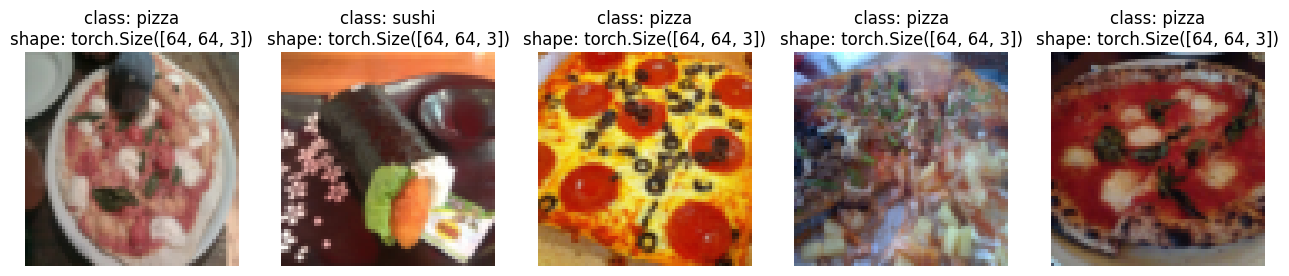

In [37]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data, 
                      n=5, 
                      classes=class_names,
                      seed=None)

For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.


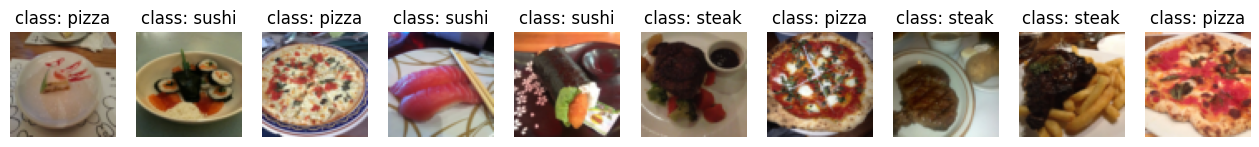

In [38]:
# Display random images from ImageFolderCustom Dataset
display_random_images(train_data_custom, 
                      n=12, 
                      classes=class_names,
                      seed=None) # Try setting the seed for reproducible images